# Logistic Model

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import itertools

import sys
assert(sys.version_info.major==3), print(sys.version)

# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # RUNNING FOR ME (MSR)

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

import io
import itertools
import warnings
warnings.filterwarnings("ignore")

### 1) Separate Dependent and Independent Predictors

In [11]:
# Read in the dataframe
df = pd.read_csv('training_data_v1.csv', skiprows=0)

In [12]:
df_1 = df.copy()

df_1 = df_1.drop(columns=['predictor','Charged Off','Y','N'],axis=1)

In [13]:
df_1['zip_code'] = df['zip_code'].astype(str)

In [14]:
df_new = pd.DataFrame()
df_new = pd.get_dummies(df_1['zip_code'])
df_1 = df_1.drop(['zip_code'],axis=1)
df_1 = pd.concat([df_1,df_new], axis=1)

In [15]:
sample = df_1.sample(frac=0.01)

### Clean Dataset and Impute Missing Data

In [16]:
# Set all Nan's to 0

for i in sample.index:
    for j in sample.columns:
        if pd.isnull(sample.at[i,j]):
            sample.at[i,j] = 0

In [17]:
x_train, x_test, y_train, y_test = train_test_split(sample.drop(columns=['Fully Paid'],axis=1), 
                                                    sample['Fully Paid'], test_size=0.15, random_state=42)

### 3) Select Most Significant Predictors Using Random Forest Regressor

In [18]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor()
rf.fit(x_train, y_train)

names = x_train.columns
performance = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

purity = 0
purity_list = []
selected_cols = []

for i in range(0,40):
    purity = purity + performance[i][0]
    purity_list.append(purity)
    selected_cols.append(performance[i][1])
    
selected_cols.append('Fully Paid')

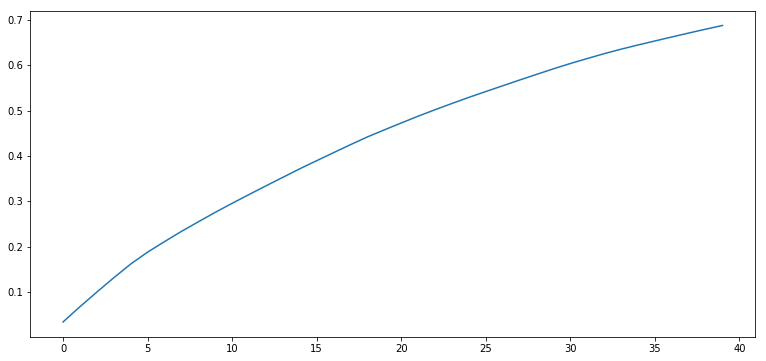

In [19]:
plt.plot(purity_list)

In [20]:
selected_cols, purity_list

(['dti',
  'mths_since_rcnt_il',
  'int_rate',
  'sub_grade',
  'tot_hi_cred_lim',
  'total_rev_hi_lim',
  'max_bal_bc',
  'avg_cur_bal',
  'total_il_high_credit_limit',
  'bc_open_to_buy',
  'installment',
  'total_acc',
  'annual_inc',
  'revol_util',
  'num_op_rev_tl',
  'funded_amnt',
  'tot_cur_bal',
  'MORTGAGE',
  'inq_last_6mths',
  'il_util',
  'revol_bal',
  'num_rev_accts',
  'num_bc_tl',
  'total_bal_il',
  'num_il_tl',
  'open_rv_12m',
  'percent_bc_gt_75',
  ' 60 months',
  'bc_util',
  'total_bc_limit',
  'open_acc',
  'total_bal_ex_mort',
  'open_rv_24m',
  'acc_open_past_24mths',
  'all_util',
  'num_actv_rev_tl',
  '441',
  'pub_rec_bankruptcies',
  'RENT',
  'open_act_il',
  'Fully Paid'],
 [0.034,
  0.06770000000000001,
  0.09990000000000002,
  0.1315,
  0.1617,
  0.188,
  0.2111,
  0.23370000000000002,
  0.2548,
  0.2757,
  0.2956,
  0.31499999999999995,
  0.33409999999999995,
  0.35289999999999994,
  0.3716999999999999,
  0.38959999999999995,
  0.40729999999999994

In [21]:
df_2 = df_1[selected_cols]

In [22]:
sample2 = df_2.sample(frac=0.1)

In [23]:
for i in sample2.index:
    for j in sample2.columns:
        if pd.isnull(sample2.at[i,j]):
            sample2.at[i,j] = 0

### 4) Instantiate and Fit Logistic Model

In [29]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(sample2.drop(columns=['Fully Paid'],axis=1), 
                                                    sample2['Fully Paid'], test_size=0.15, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegressionCV

logistic = LogisticRegressionCV(Cs=10000,penalty='l2')
logistic.fit(x_train2, y_train2)

LogisticRegressionCV(Cs=10000, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [32]:
logistic.score(x_test2, y_test2)

0.7328431372549019

### 5) Evaluate Average Interest Returns

In [153]:
# need original indices for references to racial data (indices of rows in xtest2)
original_indices = list(x_test2.index)

In [154]:
expected_interest = []
predicted_prob = logistic.predict_proba(x_test2)
for i in range(0,len(x_test2)):
    # Expected interest is predicted probability times interest rate
    expected_interest.append(predicted_prob[i][1]*x_test2.iloc[i]['int_rate'])

In [155]:
exp_int_df = pd.DataFrame(
    {'OG_Index': original_indices,
     'EI': expected_interest
    })

In [359]:
top_10_percent = round(len(x_test2)*.1)
best_ten_loans = exp_int_df.sort_values('EI',ascending=False)[0:top_10_percent]

In [360]:
successes = []
for i in best_ten_loans.index:
    successes.append(y_test2.iloc[i])

In [361]:
actual_interest = []
for i in best_ten_loans.index:
    actual_interest.append(x_test2.iloc[i]['int_rate']*y_test2.iloc[i])

In [362]:
np.mean(actual_interest)

0.11926229508196722

### 6) Checking Racial Distribution of the Results

### EDIT THE MODEL INPUTS AND OUTPUT NAMES FOR EACH MODEL; MAKE DISCRIMINATION PAGE

In [180]:
racial_data = pd.read_csv('Race_by_zip_final.csv')

In [462]:
# Takes in a list of indices of loans referenced in the orginial Lending Club data frame, the original Lending Club data frame
# itself, and the data frame storing the racial distributions across three-digit zip code areas in the United States

# returns a one vs. rest percentage: the average percentage of a given racial group specified by parameter 'prop'
# (default White) underlying the list of loans

def get_demographic_data(list_of_indices, lending_data, race_data, prop_=['White Proportion','Black Proportion','Asian Proportion','Other Proportion', 
                                                                          'Hispanic Proportion','Non-Hispanic Proportion']):
    
    average_proportions = {}
    
    for race in prop_:
        #print(race)
        race_proportion = []
        for i in list_of_indices:
            
            zipCode = lending_data.loc[i]['zip_code']

            # accounting for the fact that Lending Club let users input Zip Codes that don't exist in the USA
            try:
                proportion = ((race_data.loc[race_data['Zip Code'] == zipCode][race]).values)
                race_proportion.append(float(proportion))
            except:
                continue
            

        average_proportions[race] = sum(race_proportion)/len(race_proportion)
    
    return average_proportions

In [463]:
#['White Proportion', 'Black Proportion',

#       'Asian Proportion', 'Other Proportion', 'Hispanic Proportion','Non-Hispanic Proportion']

racial_percentage = {}
#for race in racial_proportions:
racial_percentage=get_demographic_data(best_ten_loans['OG_Index'],df,racial_data)

In [ ]:
((race_data.loc[race_data['Zip Code'] == zipCode][prop_]).values)

In [464]:
racial_percentage

{'White Proportion': 70.34472488927715,
 'Black Proportion': 13.840647749334703,
 'Asian Proportion': 5.350783918398047,
 'Other Proportion': 10.46603735448333,
 'Hispanic Proportion': 17.480644536615213,
 'Non-Hispanic Proportion': 82.51922679652233}

In [432]:
a=(racial_data.loc[racial_data['Zip Code'] == 999]['Black Proportion']).values
float(a)

3.340898098887608

In [375]:
np.mean([1,2,3,4,5])

3.0

In [397]:
get_demographic_data(best_ten_loans.index,df,racial_data)

{'White Proportion': array([], shape=(0, 1), dtype=float64)}

In [357]:
racial_data.columns

Index(['Unnamed: 0', 'Zip Code', 'White Proportion', 'Black Proportion',
       'Asian Proportion', 'Other Proportion', 'Hispanic Proportion',
       'Non-Hispanic Proportion'],
      dtype='object')

In [ ]:
# Demographic Distribution Correction Algorithm

# slider starts at index, measures from 0 index to 122
# go through each, classifies each as a white or a nonwhite loan
# calculates percentage white loans in its current pool
# if problem, holds the top half of loans as is and then slides down from 51 + i - to 122 + i

def demographic_correction(best_x_loans, racial_group, percentage_desired, expected_interest_dataframe, lending_club_df):
    x_percent_length = len(best_x_loans)
    length_of_half = int(x_percent_length/2)

    all_loans_ordered = expected_interest_dataframe.sort_values('EI',ascending=False)

    distribution = get_demographic_data(best_x_loans['OG_Index'],df,racial_data)

    if distribution > parity_level:
        top_returns = best_x_loans[0:length_of_half]

    loan_bag = None
    i = 0
    while distribution  percentage_desired:
        i = i + 1

        # slide through
        bottom_returns = all_loans_ordered[length_of_half+i:2*(length_of_half)+i]
        loan_bag = top_returns.append(bottom_returns)

        # test if current bag of loans meets paprity standard
        distribution = get_demographic_data(loan_bag['OG_Index'],df,racial_data)